## Vehicle Detection Project

### Hao Zhuang, 2018

In [278]:
import numpy as np
import pickle
import cv2
import glob
import time

# sklearn lib
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

try:
    # sklearn > 0.17
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
#from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label 
from skimage.feature import hog

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

    
    
%matplotlib inline



### Load Training Data provided in Udacity lectures

### Visualize Car Images

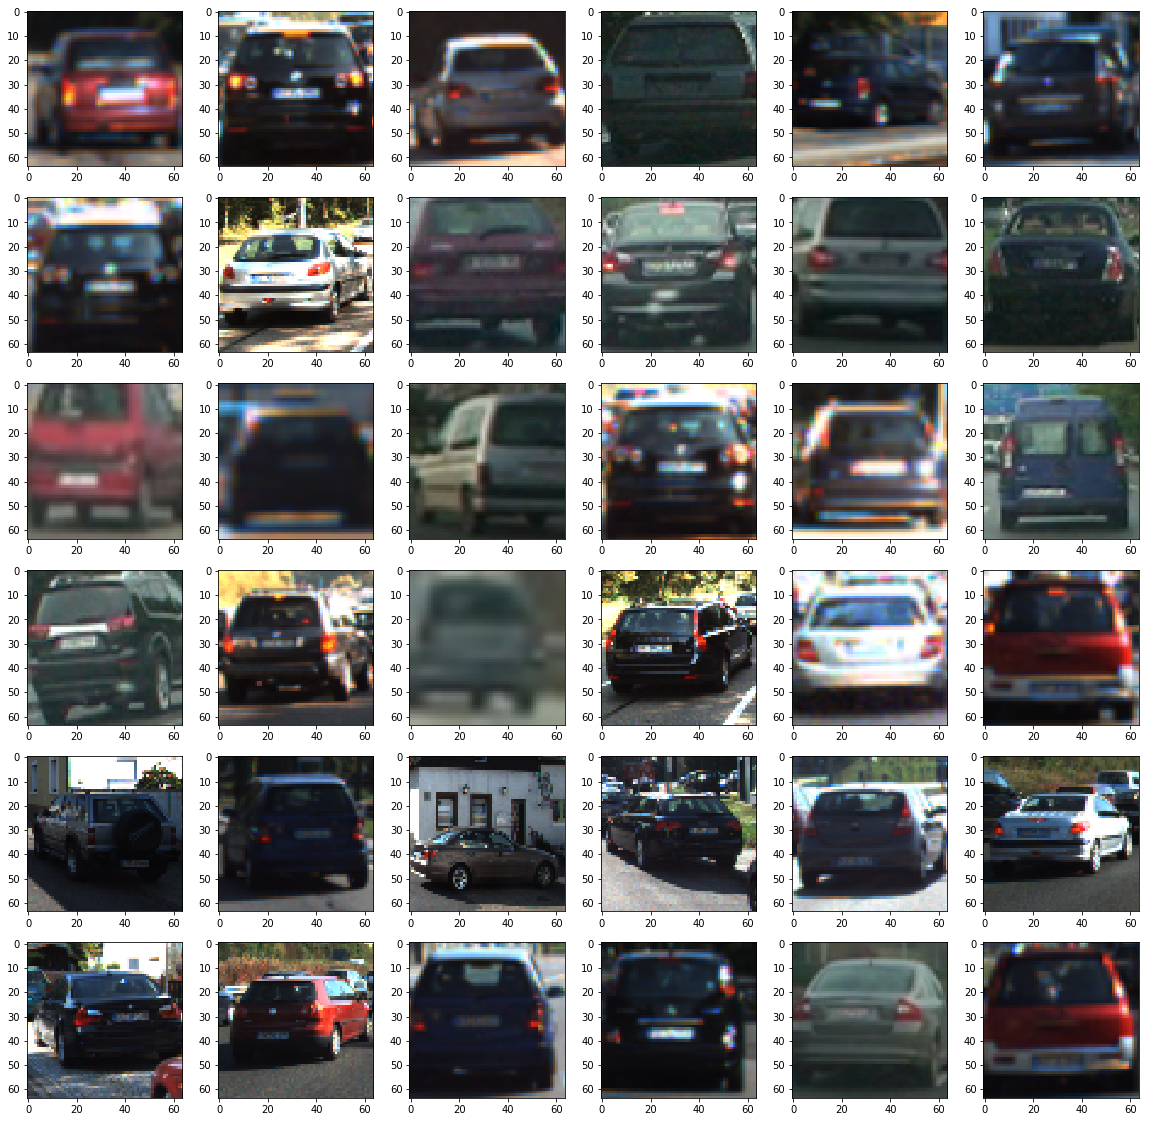

In [279]:

car_images = glob.glob('udacity_dataset/vehicles/*/*.png')
row = 6
col = 6
fig, axs = plt.subplots(row, col, figsize=(20, 20)) 
axs = axs.ravel()


for i in np.arange(row*col):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #axs[i].set_title('vehicle', fontsize=15)
    axs[i].imshow(img)
    
 

### Visualize No Car Images

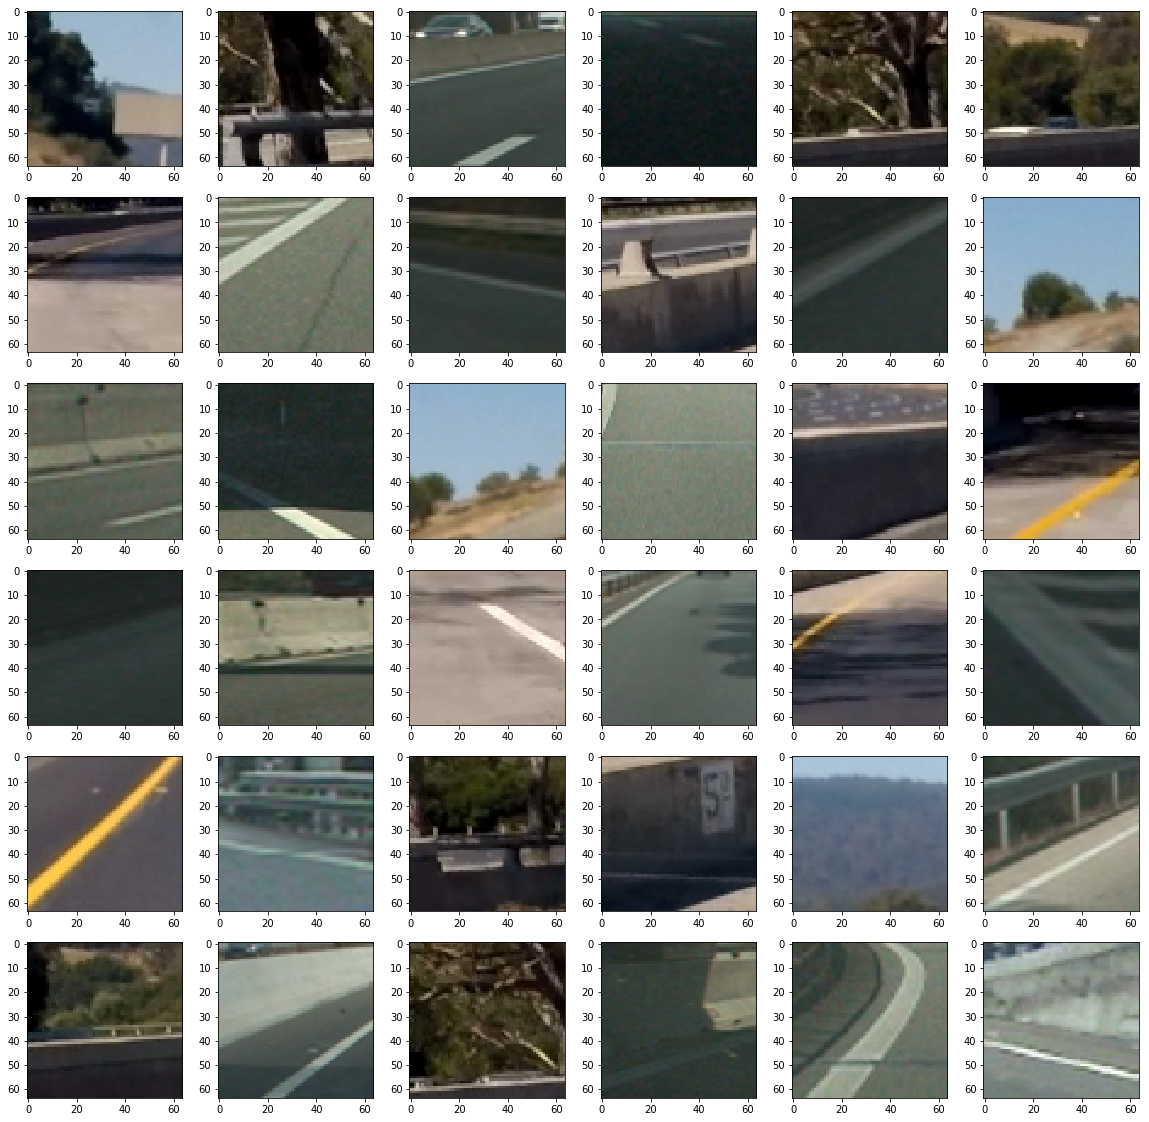

In [280]:
noncar_images = glob.glob('udacity_dataset/non-vehicles/*/*.png')
row = 6
col = 6
fig, axs = plt.subplots(row, col, figsize=(20, 20)) 
axs = axs.ravel()

for i in np.arange(row*col):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #axs[i].set_title('no vehicle', fontsize=15)
    axs[i].imshow(img)   

In [281]:
print('Car images #:', len(car_images), 'No Car Images #: ', len(noncar_images))

Car images #: 8792 No Car Images #:  8968


### Convert Images to HOG (Histogram of Oriented Gradients)

In [282]:
"""
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=8, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    return_list = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)    
    hog_features = return_list[0]        
        #return features, hog_image    
    if vis == True:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:  
        return hog_features
"""

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    


Visualize HOG on example image

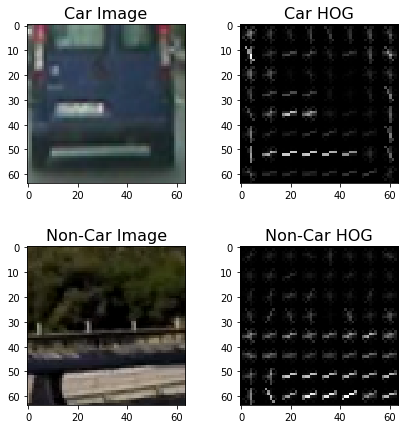

In [7]:
pos = 1
car_img = mpimg.imread(car_images[pos])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[pos])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

"""
pos = 2
car_img = mpimg.imread(car_images[pos])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[pos])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
"""

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Extract HOG Features from Car and Non-Car Images

In [8]:


"""
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features_simple(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features    

num_items = 10        
car_features = extract_features_simple(car_images[0:num_items], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features_simple(noncar_images[0:num_items], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, num_items)
    #print(car_ind)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')
"""


"\n# Define a function to compute binned color features  \ndef bin_spatial(img, size=(32, 32)):\n    # Use cv2.resize().ravel() to create the feature vector\n    features = cv2.resize(img, size).ravel() \n    # Return the feature vector\n    return features\n\n# Define a function to compute color histogram features  \ndef color_hist(img, nbins=32, bins_range=(0, 256)):\n    # Compute the histogram of the color channels separately\n    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)\n    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)\n    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)\n    # Concatenate the histograms into a single feature vector\n    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))\n    # Return the individual histograms, bin_centers and feature vector\n    return hist_features\n\n\ndef extract_features_simple(imgs, cspace='RGB', spatial_size=(32, 32),\n        

In [154]:

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace='RGB', orient=11, 
                     pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0):
    # Create a list to append feature vectors to
    features = []    
    size = (16, 16)
    hist_bins = 32
    hist_range = (0, 256)
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
 
        spatial_features = bin_spatial(image, size)
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)                
        features_line = np.concatenate((spatial_features, hist_features, hog_features))
        features.append(features_line)
    # Return list of feature vectors
    return features


### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

In [155]:
# Feature extraction parameters
colorspace = 'YCrCb'#'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)

notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
X_scaler = StandardScaler().fit(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
#rand_state = np.random.randint(0, 100)
rand_state = 32

X_train_, X_test_, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

X_train = X_scaler.transform(X_train_)
X_test = X_scaler.transform(X_test_)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

332.92 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052


## Train a SVM Classifier

In [156]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVM Classifier...')
# Check the score of the SVC
print('Test Accuracy of SVM Classifier = ', round(svc.score(X_test, y_test), 10))

4.78 Seconds to train SVM Classifier...
Test Accuracy of SVM Classifier =  0.9901463964


In [157]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0, 10]}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters)
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [158]:
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

t = time.time()
svc.fit(X_train, y_train)
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 10))

-18.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9898648649


In [160]:
XX= X_scaler.transform(X)
svc.fit(XX, y)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 10))

80.95 Seconds to train SVC...
Test Accuracy of SVC =  1.0


### Check the prediction time for a single sample

In [161]:
t=time.time()
n_predict = 20
print(X_test[0])#0:n_predict])
#print('My SVC predicts: ', svc.predict(X_test[0]))
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

[-0.26461375 -0.51389575 -0.5808497  ...,  0.17248727 -0.56259542
 -0.33519295]
My SVC predicts:      [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.
  1.  0.]
For these 20 labels:  [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.
  1.  0.]
0.0031 Seconds to predict 20 labels with SVC


## Using Classifier to Detect Cars in an Image

In [360]:
# Define a single function that can extract features using hog sub-sampling and make predictions

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, 
              show_all=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    size = (16, 16)
    hist_bins = 32
    hist_range = (0, 256)
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))          
            spatial_features = bin_spatial(subimg, size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)                
            features_line = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            
            features = X_scaler.transform(features_line)
            test_prediction = svc.predict(features)
            #print(test_prediction)
            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),
                                   (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return rectangles


### Test `Find_Cars` on an Example Image

In [361]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

2 boxes found in image


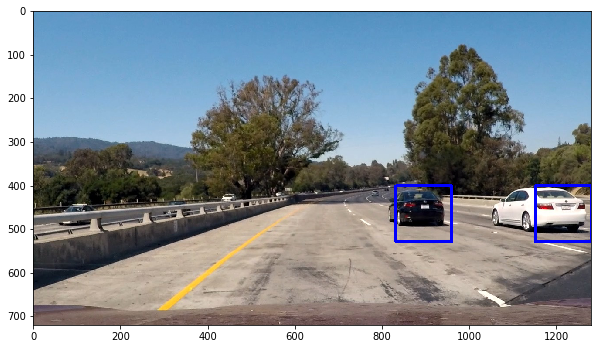

In [362]:
#test_img = mpimg.imread('./test_images/test6.jpg')
test_img_file = './test_images/test1.jpg'
test_img = mpimg.imread(test_img_file)
#plt.imshow(test_img)

ystart = 400
ystop = 656
scale = 2
#colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
show_all_rectangles= True#False
show_all_rectangles= False
rectangles = find_cars(test_img, ystart, ystop, scale, 
                       colorspace, hog_channel, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, None, None,show_all_rectangles)

print(len(rectangles), 'boxes found in image')
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


### Show All Potential Search Areas

Becuase the size and position of cars in the image will be different depending on their distance from the camera, `find_cars` will have to be called a few times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  7


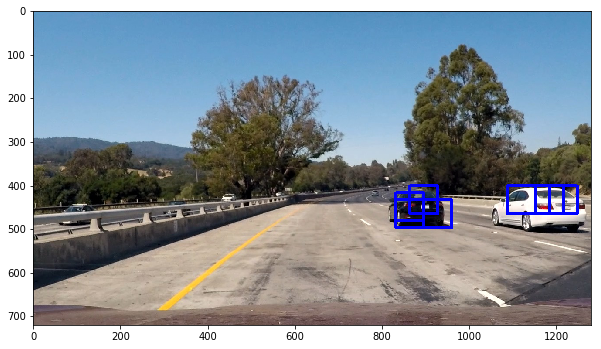

In [364]:
#test_img = mpimg.imread(test_img_file)

rects = []
show_all_rectangles= True#False
show_all_rectangles= False

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

ystart = 432
ystop = 496
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

ystart = 448
ystop = 512
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)#, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  7


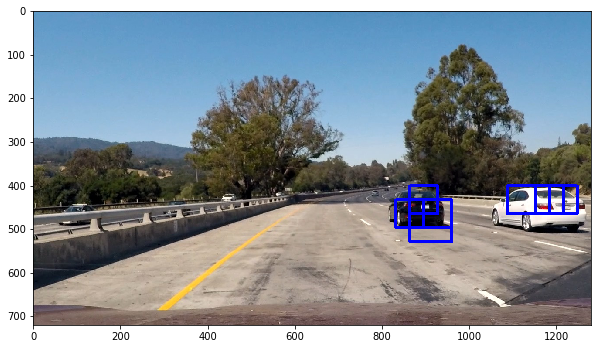

In [371]:
#test_img = mpimg.imread('./test_images/test1.jpg')

rects = []
show_all_rectangles = False #True
#show_all_rectangles= True#False
ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,  X_scaler,
                       orient, pix_per_cell, cell_per_block, None, None, 
                       show_all_rectangles))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,  X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, 
                       show_all_rectangles))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)#, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  3


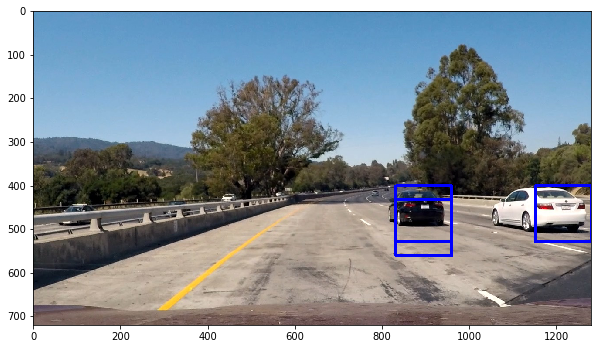

In [373]:
#test_img = mpimg.imread('./test_images/test1.jpg')

rects = []
show_all_rectangles = True
show_all_rectangles = False
ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,  X_scaler,
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,  X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)#, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  5


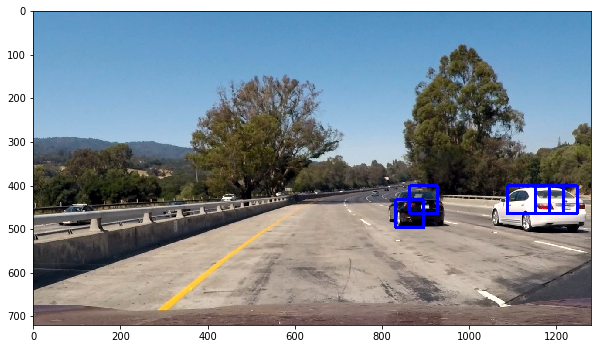

In [377]:
#test_img = mpimg.imread('./test_images/test1.jpg')

rects = []
#show_all_rectangles = True#False
show_all_rectangles = False
ystart = 400
ystop = 596
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,  X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,  X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)#, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Combine Various Sliding Window Searches

[400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512, 520, 528, 536, 544, 552, 560, 568, 576, 584, 592, 600, 608, 616, 624, 632, 640, 648, 656, 664, 672, 680, 688, 696]


In [505]:
test_img_file = './test_images/test1.jpg'
test_img = mpimg.imread(test_img_file)
 
#colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
show_all_rectangles = False

ystarts = [400, 405, 410] #[i for i in range(400, 700, 8)]
y_scale = [1, 1.5, 2, 2.5, 3]                     
#y_step = [i * 16 for i in y_scale]
#print(y_step)
y_stop = 680

#ystop_arr = [i +  for i in ystart_arr]
#show_all_rectangles=True
show_all_rectangles=False
rectangles = []
for i in range(len(y_scale)):
    for j in range(len(ystarts)):
        scale = y_scale[i]
        ystart = ystarts[j]
        step = int((y_stop - ystart)//(scale * pix_per_cell) )    
        ystop = int(ystart + step * scale * pix_per_cell) 
        print(scale, step, ystart, ystop)
        rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

rectangles = [item for sublist in rectangles for item in sublist] 
   

1 17 400 672
1 17 405 677
1 16 410 666
1.5 11 400 664
1.5 11 405 669
1.5 11 410 674
2 8 400 656
2 8 405 661
2 8 410 666
2.5 7 400 680
2.5 6 405 645
2.5 6 410 650
3 5 400 640
3 5 405 645
3 5 410 650


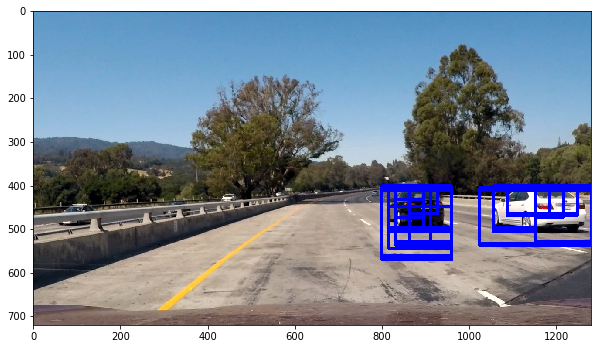

In [506]:
# print(rectangles)

test_img_rects = draw_boxes(test_img, rectangles)#, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects) 

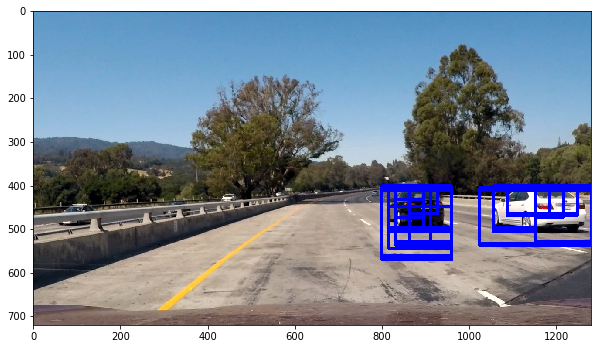

In [507]:



test_img_rects = draw_boxes(test_img, rectangles)#, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Heatmap

In [508]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects


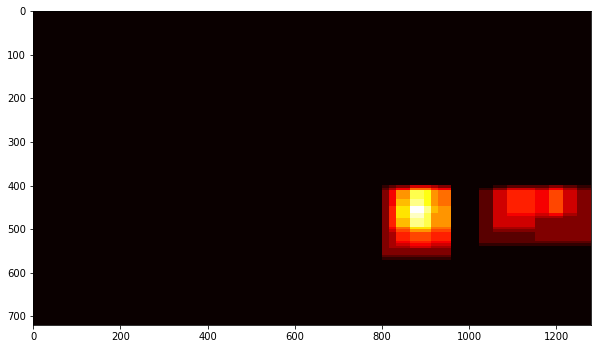

In [509]:
# Test out the heatmap
heatmap_img_origin = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img_origin, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')



### Apply a Threshold to the Heatmap

In [510]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold  
    #print(heatmap <= threshold)
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map    
    return heatmap


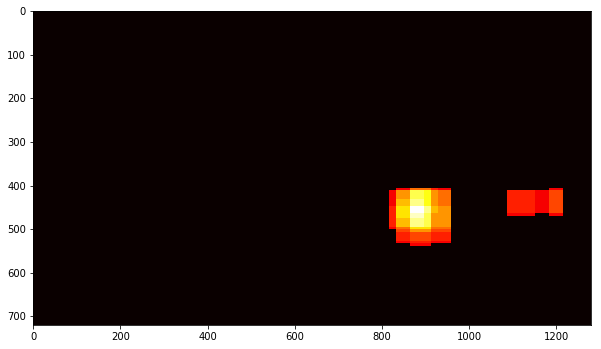

In [511]:
threshold = 5
heatmap_img_new = apply_threshold(heatmap_img, threshold=threshold)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img_new, cmap='hot')


2 cars found


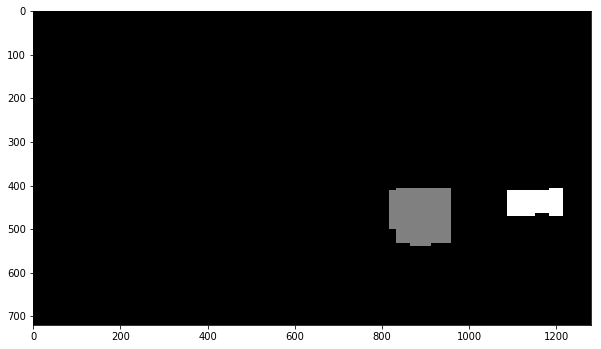

In [512]:
labels = label(heatmap_img_new)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

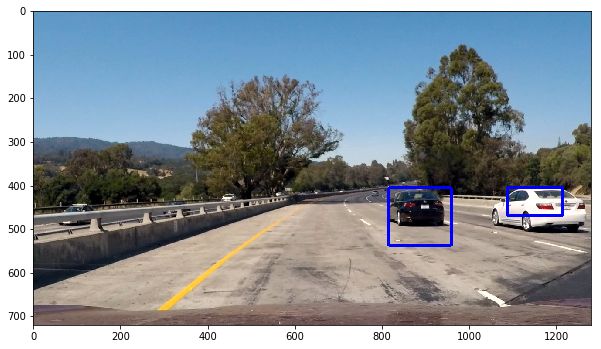

In [513]:


# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Put it All Together

In [514]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystarts = [400, 405, 410] #[i for i in range(400, 700, 8)]
    y_scale = [1, 1.5, 2, 2.5, 3]               
    #y_step = [i * 16 for i in y_scale]
    #print(y_step)
    y_stop = 680

    #ystop_arr = [i +  for i in ystart_arr]
    #show_all_rectangles=True
    show_all_rectangles=False
    rectangles = []
    for i in range(len(y_scale)):
        for j in range(len(ystarts)):
            scale = y_scale[i]
            ystart = ystarts[j]
            step = int((y_stop - ystart)//(scale * pix_per_cell) )    
            ystop = int(ystart + step * scale * pix_per_cell) 
            #print(scale, step, ystart, ystop)
            rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                               orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

    rectangles = [item for sublist in rectangles for item in sublist] 
   
    """
    y_stop = 680
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc,X_scaler,
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc,X_scaler,
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, None, None))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    """
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, threshold)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img




Run the pipeline on all the test images.

### Run a Video Through the Pipeline (primitive version)
This only processes a frame at a time without accounting for information from previous frames

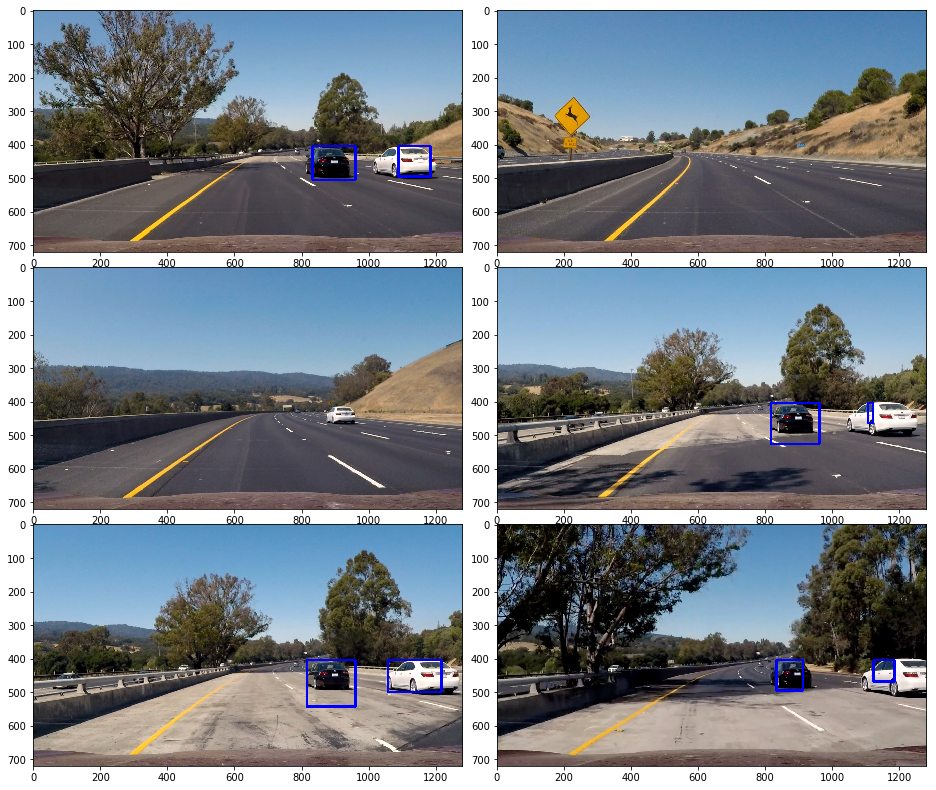

In [515]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace=0.04, wspace=0.08)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))


In [502]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 97%|█████████▋| 38/39 [01:40<00:02,  2.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 2min, sys: 276 ms, total: 2min
Wall time: 1min 41s


In [504]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

### Define a Class to Store Data from Vehicle Detections

In [516]:
class VD():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_boxes = [] 
        self.mem = 10
        
    def add_rects(self, rects):
        self.prev_boxes.append(rects)
        if len(self.prev_boxes) >= self.mem:
            self.prev_rects = self.prev_boxes[-self.mem::]

    def process_frame_for_video(self, img):

        rectangles = []

        colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 11
        pix_per_cell = 16
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

        ystarts = [400, 405, 410] #[i for i in range(400, 700, 8)]
        y_scale = [1, 1.5, 2, 2.5, 3]               
        #y_step = [i * 16 for i in y_scale]
        #print(y_step)
        y_stop = 680

        #ystop_arr = [i +  for i in ystart_arr]
        #show_all_rectangles=True
        show_all_rectangles=False
        rectangles = []
        for i in range(len(y_scale)):
            for j in range(len(ystarts)):
                scale = y_scale[i]
                ystart = ystarts[j]
                step = int((y_stop - ystart)//(scale * pix_per_cell) )    
                ystop = int(ystart + step * scale * pix_per_cell) 
                #print(scale, step, ystart, ystop)
                rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                                   orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles))

        rectangles = [item for sublist in rectangles for item in sublist] 
   
        # add detections to the history
        if len(rectangles) > 0:
            self.add_rects(rectangles)

        heatmap_img = np.zeros_like(img[:,:,0])
        for rect_set in self.prev_boxes:
            heatmap_img = add_heat(heatmap_img, rect_set)
        #heatmap_img = apply_threshold(heatmap_img, threshold)
        heatmap_img = apply_threshold(heatmap_img, 2 + len(vd.prev_boxes)//2)

        labels = label(heatmap_img)
        draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
        return draw_img



### Pipeline for Processing Video Frames

### Run a Video Through the Pipeline (advanced version)
This processes each frame while accounting for information from previous frames

In [ ]:


vd = VD() 
test_out = 'videos/test_video_small.mp4'
clip_test  = VideoFileClip('project_video.mp4').subclip(1,20)
#clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(vd.process_frame_for_video)
%time clip_test_out.write_videofile(test_out, audio=False)

[MoviePy] >>>> Building video videos/test_video_small.mp4
[MoviePy] Writing video videos/test_video_small.mp4



 30%|██▉       | 141/476 [04:25<10:30,  1.88s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out))

In [ ]:
vd = VD()

proj_out_file = 'videos/project_video.mp4'
proj = VideoFileClip('project_video.mp4') 
proj_out = proj.fl_image(vd.process_frame_for_video)
%time proj_out.write_videofile(proj_out_file, audio=False)

In [449]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))